### Тестовое задание

Исходные данные – корпус новостей с сайта Lenta.ru (https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/). Нужно обучить классификатор новостей по рубрикам (поле topic), для чего:
1.    Предобработать тексты и получить признаковое пространство
2.    Выбрать модель или несколько моделей для обучения
3.    Разделить датасет на обучающую, тестовую и контрольную выборки
4.    Выбрать метрику для оценки результатов

- Все шаги должны быть кратко откомментированы, выбор тех или иных методов, метрик, подходов – мотивирован. 

#### 1. Load dataset

In [175]:
# import libs, define system path

import os, gc
import warnings
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    way = '/content/gdrive/My Drive/Lenta/'
    slash = '/'
else:
    way = os.getcwd() + '\\'
    slash='\\'
    
warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# define params 

required_dataset_size = 210000
test_rate = 0.1             # 10% of all data is for test
train_val_rate = 0.8        # 80% to 20% of rest part is for train\val

In [0]:
# load and clean up the data

df = pd.read_csv(way + 'lenta-ru-news.csv', usecols=['text', 'topic'], nrows=required_dataset_size)
df['topic'].fillna('Прочее', inplace=True) # fill missed topics with separate labels
df.dropna(axis=0, inplace=True) # drop samples with empty text

In [178]:
# check balance of classes
'''
Dataset is multiclassed and highly imbalanced, metric to be used is: 

sklearn.metrics.f1_score with average=’micro’ parameter.

'''
df['topic'].value_counts()

Россия               32669
Мир                  30636
Спорт                20788
Силовые структуры    16619
Бывший СССР          16260
Экономика            14902
Культура             13328
Интернет и СМИ       12996
Наука и техника      12365
Из жизни              8738
Ценности              7763
Бизнес                7296
Дом                   6795
Путешествия           6407
69-я параллель        1268
Крым                   666
Культпросвет           340
Легпром                113
Прочее                  38
Библиотека               8
Оружие                   3
МедНовости               1
Name: topic, dtype: int64

In [0]:
# change topics with <5 samples only to 'Прочее'

df['topic'][df['topic'].isin(df['topic'].value_counts()[df['topic'].value_counts()<=5].index.tolist())]='Прочее'

In [180]:
# just check

df['topic'].value_counts()

Россия               32669
Мир                  30636
Спорт                20788
Силовые структуры    16619
Бывший СССР          16260
Экономика            14902
Культура             13328
Интернет и СМИ       12996
Наука и техника      12365
Из жизни              8738
Ценности              7763
Бизнес                7296
Дом                   6795
Путешествия           6407
69-я параллель        1268
Крым                   666
Культпросвет           340
Легпром                113
Прочее                  42
Библиотека               8
Name: topic, dtype: int64

In [0]:
# create target column

df['target'] = df['topic'].map(dict(zip(df['topic'].unique(),np.arange(0, len(df['topic'].unique()))))) 

In [182]:
df.head()

,text,topic,target
0,Вице-премьер по социальным вопросам Татьяна Го...,Россия,0
1,Австрийские правоохранительные органы не предс...,Спорт,1
2,Сотрудники социальной сети Instagram проанализ...,Путешествия,2
3,С начала расследования российского вмешательст...,Мир,3
4,Хакерская группировка Anonymous опубликовала н...,Мир,3


#### 2. Split data to train, validation and test sets

In [183]:
indices=np.arange(len(df))

np.random.shuffle(indices)

tt_split = np.int(len(indices)*test_rate)
tt_indices = indices[tt_split:]
test_indices = indices[:tt_split]

tv_split = np.int(len(tt_indices)*train_val_rate)
val_indices = tt_indices[tv_split:]
train_indices = tt_indices[:tv_split]

X_train=df['text'].values[train_indices]
X_val=df['text'].values[val_indices]
X_test=df['text'].values[test_indices]

y_train=df['target'].values[train_indices]
y_val=df['target'].values[val_indices]
y_test=df['target'].values[test_indices]

len(X_train), len(X_val), len(X_test)

(151200, 37800, 20999)

#### 3. Vectorize samples (= get feature matrix)

In [184]:
''' 
two actions here:
    - count each word appearances in all train samples -> to sparce matrix 
    - transform each word count to its frequency in document
Can be done separately with CountVectorizer() and then with TfidfTransformer(), but TfidfVectorizer() make it all-in-one 
''' 

vectorizer = TfidfVectorizer()
X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)
X_val_v = vectorizer.transform(X_val)

X_train_v.shape, X_test_v.shape, X_val_v.shape

((151200, 480056), (20999, 480056), (37800, 480056))

#### 4. Model selection and test

In [185]:
'''
Options: neural network, tree/random forest or logistic regression.

For this particular case (limited time for task completion and >1e6 features in dataset) logistic regression 
is the most suitable model because of: fast fit, minimum params to tune. 
'''
# define classifier instance, fix max_iter=5 

news_clf = SGDClassifier(loss='log', penalty='l2', random_state=24, 
              max_iter=5, class_weight='balanced')
news_clf.fit(X_train_v, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=24, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [186]:
# fit model with default params, this will be baseline

y_pred = news_clf.predict(X_val_v)
baseline = f1_score(y_val, y_pred, average='micro')

print('Validation set score with default parameters (=baseline): %2.4f' % baseline) 

Validation set score with default parameters (=baseline): 0.7622


#### 5. Model tuning

Take validation score as baseline. 

##### 5.1. Parameters tuning

In [0]:
# set space of tunable params. Learning rate calculated automatically in SGDClassifier so not included here

param_grid = {
                'penalty': ['l1', 'l2'],
                'alpha' : np.logspace(-8 , -4, 10)
                                                        } 

In [188]:
# no need validation data at the moment as cross-validation used

cv_score = RandomizedSearchCV(news_clf, param_grid, n_iter=8, scoring='f1_micro', 
                              n_jobs=-1, cv=5, verbose=1, random_state=24)
cv_score.fit(X_train_v, y_train)

print('Best score on cross-validation is: %2.4f' % cv_score.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 16.7min finished


Best score on cross-validation is: 0.8507


In [189]:
# best parameters found

cv_score.best_params_

{'alpha': 5.994842503189409e-07, 'penalty': 'l2'}

In [0]:
# best classifier

Lenta_clf = cv_score.best_estimator_

In [191]:
# check score on validation set, compare with baseline

y_pred = Lenta_clf.predict(X_val_v)
score = f1_score(y_val, y_pred, average='micro')

print('Validation set score before tuning: %2.4f' % baseline) 
print('Validation set score after tuning: %2.4f' % score) 

Validation set score before tuning: 0.7622
Validation set score after tuning: 0.8534


##### 5.2 Tuning of max_iter

Best "max_iter" value is: 8, best validation accuracy is: 0.8553


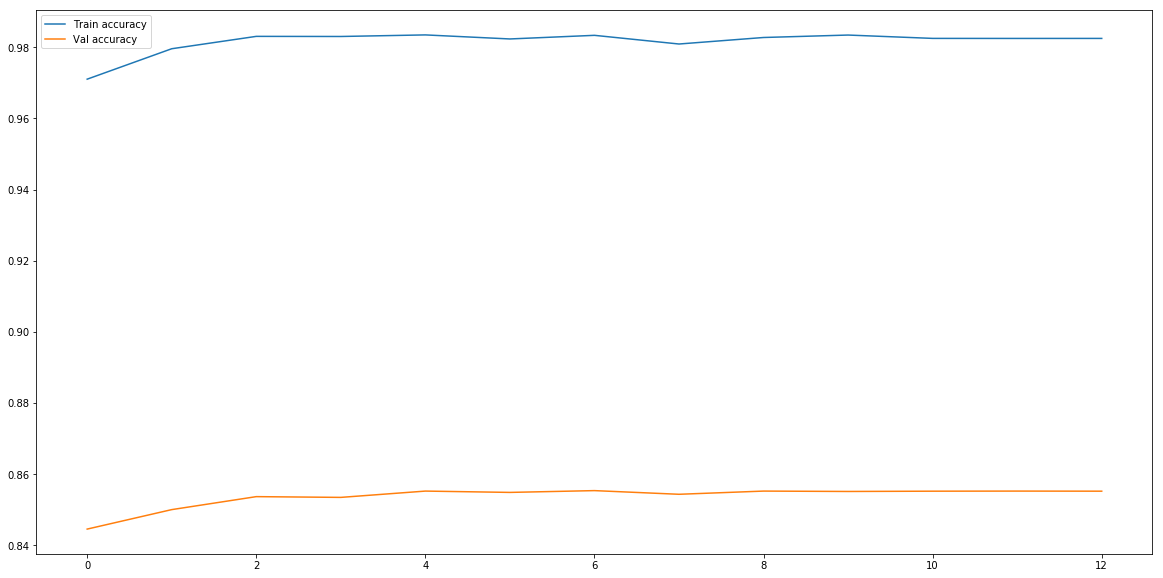

In [195]:
# increment max_iter by 1 and sind best validation score 

train_history = []
val_history = []

for max_iter in range(2, 15, 1):
  Lenta_clf.max_iter=max_iter 
  Lenta_clf.fit(X_train_v, y_train)  

  y_train_pred = Lenta_clf.predict(X_train_v)    
  train_score = f1_score(y_train, y_train_pred, average='micro') 
  train_history.append(train_score)

  y_val_pred = Lenta_clf.predict(X_val_v)    
  val_score = f1_score(y_val, y_val_pred, average='micro') 
  val_history.append(val_score)

  # print('Ep.%i, train acc.=%2.4f, val acc.=%2.4f' %  (max_iter, train_score, val_score))

val_array = np.array(val_history)

best_iter = np.argmax(val_array)+2

plt.figure(figsize=(20,10))
plt.plot(train_history)
plt.plot(val_history)
plt.legend(('Train accuracy', 'Val accuracy'));

print('Best "max_iter" value is: %i, best validation accuracy is: %2.4f' % (best_iter, max(val_array)))

#### 6. Result on the test set

In [0]:
# set classifier max_iter to optimum value

Lenta_clf.max_iter = best_iter    

In [194]:
# predict test set

Lenta_clf.fit(X_train_v, y_train)    
y_pred = Lenta_clf.predict(X_test_v)
score = f1_score(y_test, y_pred, average='micro')

print('Final score on the test set: %2.4f' % score)

Final score on the test set: 0.8562
